##The Functional and Sequential Keras API##
in this notebook we will explore some examples of the sequential api that we know, and the functional api which we will see for the first time today.  The sequential api is a useful tool, but it lacks some functionality that we may want to take advantage of when building more complicated networks.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Input, Concatenate
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import numpy as np
from time import time

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
# let's take a look at the data (TODO)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(np.unique(y_train))

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
[0 1 2 3 4 5 6 7 8 9]


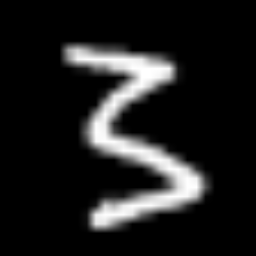

In [25]:
img = tf.image.resize(x_train[np.random.randint(0, len(x_train))], (256, 256))
img = tf.keras.utils.array_to_img(img)
img

In [26]:
def train_validation_split(x_train, y_train, val_fraction=.2, shuffle=True):
  # generate a random permutation of the indicies (shuffle the data)
  # this ensures the distribution of examples is the same along the split
  indices = np.random.permutation(x_train.shape[0])
  # calculate the index where we wish to split
  split_index = int(x_train.shape[0] * val_fraction)
  # splite the permutation into sets of the desired size
  train_indices, val_indices = indices[split_index:], indices[:split_index]
  # return (x_train, y_train), (x_val, y_val)
  return (x_train[train_indices], y_train[train_indices]), (x_train[val_indices], y_train[val_indices])

In [27]:
(x_train, y_train), (x_val, y_val) = train_validation_split(x_train, y_train)
# let's look at it again (TODO)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(48000, 28, 28, 1) (48000,)
(12000, 28, 28, 1) (12000,)


In [28]:
def build_sequential_model(conv_filters,
                           conv_size,
                           dense_layers,
                           image_size=(28, 28, 1),
                           learning_rate=1e-3,
                           n_classes=10,
                           activation='selu'):
  # create the model object
  model = tf.keras.Sequential()
  # add an input layer (this step is only needed for the summary)
  model.add(Input(image_size))
  # add the convolutional layers
  for (filters, kernel) in zip(conv_filters, conv_size):
    model.add(Conv2D(filters=filters, kernel_size=(kernel, kernel), activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  # flatten
  model.add(Flatten())
  # add dense layers
  for neurons in dense_layers:
    model.add(Dense(neurons, activation=activation))
  # classification output
  model.add(Dense(n_classes, activation=tf.keras.activations.softmax))
  # optimizer
  opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate, 
                                  beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.99)
  # compile the model
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt, 
                metrics=['sparse_categorical_accuracy'])

  # Generate an ASCII representation of the architecture
  print(model.summary())
  
  return model
  

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 16)        2064      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 20)               

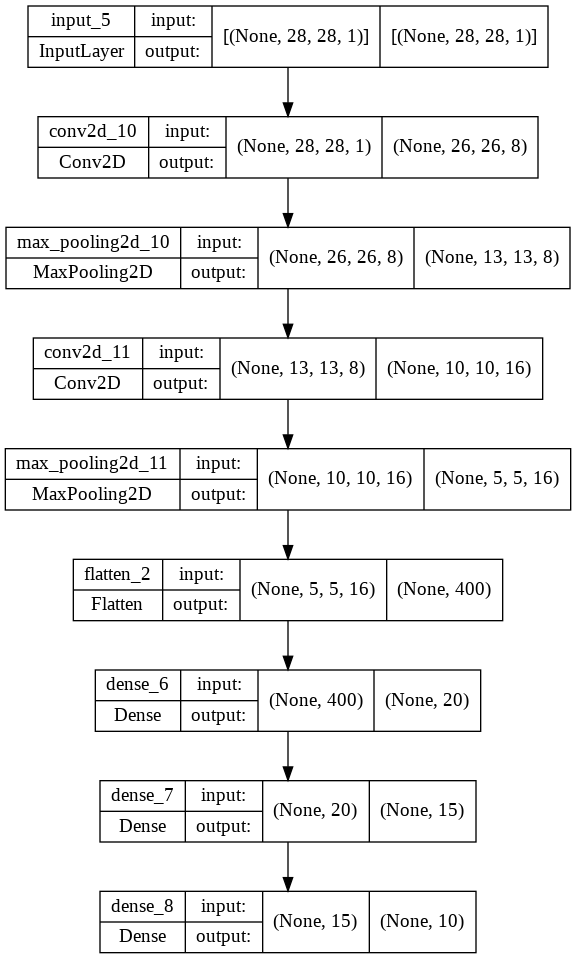

In [33]:
model_arguments = {  # TODO: define parameters
    'conv_filters' : [8, 16],
    'conv_size' : [3, 4],
    'dense_layers' : [20, 15]
}

seq_model = build_sequential_model(**model_arguments)
# generate a graphical representation of the neural network
plot_model(seq_model, show_shapes=True, show_layer_names=True, to_file='seq_model.png')
# display the graphical representation
Image('seq_model.png')

In [34]:
def build_functional_model(conv_filters,
                           conv_size,
                           dense_layers,
                           image_size=(28, 28, 1),
                           learning_rate=1e-3,
                           n_classes=10,
                           activation='selu'):
  # define the input layer (required)
  inputs = Input(image_size)
  # set reference x separately to keep track of the input layer
  x = inputs
  # construct the convolutional part
  for (filters, kernel) in zip(conv_filters, conv_size):
    # each layer is a function of the previous layer, we can reuse reference x
    x = Conv2D(filters=filters, kernel_size=(kernel, kernel), activation=activation)(x)
    # pooling after a convolution (or two) is a standard simple technique
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  # flatten
  x = Flatten()(x)
  # construct the dense part
  for neurons in dense_layers:
   x = Dense(neurons, activation=activation)(x)
  # classification output
  outputs = Dense(n_classes, activation=tf.keras.activations.softmax)(x)
  # optimizer
  opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate, 
                                  beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.99)
  # when we compile the model we must specify inputs and outputs
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs],
                        name=f'cnn_model_{"%02d" % time()}')
  # compile the model
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt, 
                metrics=['sparse_categorical_accuracy'])
  
  # Generate an ASCII representation of the architecture
  print(model.summary())
  
  return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 10, 16)        2064      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 400)               0         
                                                                 
 dense_9 (Dense)             (None, 20)               

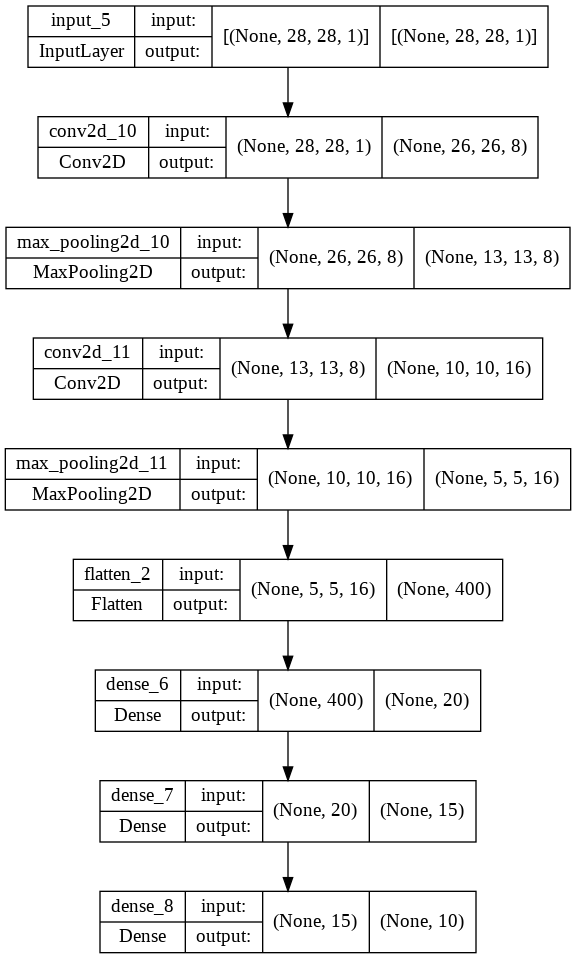

In [35]:
fun_model = build_sequential_model(**model_arguments)
# generate a graphical representation of the neural network
plot_model(seq_model, show_shapes=True, show_layer_names=True, to_file='fun_model.png')
# display the graphical representation
Image('fun_model.png')

In [36]:
def build_parallel_functional_model(conv_filters,
                           conv_size,
                           dense_layers,
                           image_size=(28, 28, 1),
                           learning_rate=1e-3,
                           n_classes=10,
                           activation='selu'):
  # define the input tensor
  inputs = Input(image_size)

  x = inputs
  # construct the convolutional block
  for (filters, kernel) in zip(conv_filters, conv_size):
    # here we keep track of the input of each block
    ins = x
    # there are two paths through which the data and gradient can flow
    # 1st path is x:
    x = Conv2D(filters=filters, kernel_size=(kernel, kernel), activation=activation, padding='same')(ins) # TODO
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) # TODO
    # 2nd path is y:
    y = Conv2D(filters=filters, kernel_size=(1, 1), activation=activation, padding='same')(ins) # TODO
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(y) # TODO
    # both paths' outputs are concatenated across the filter dimension
    x = Concatenate()([x, y])
    # and then an additional convolution that reduces the total filter dimension
    # is performed
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation=activation)(x)

  # flatten
  x = Flatten()(x)
  # construct the dense part
  for neurons in dense_layers:
   x = Dense(neurons, activation=activation)(x)
  # classification output
  outputs = Dense(n_classes, activation=tf.keras.activations.softmax)(x)

  opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate, 
                                  beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.99)
  # build the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs,
                        name=f'cnn_model_{"%02d" % time()}')
  # compile the model
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt, 
                metrics=['sparse_categorical_accuracy'])
  
  # Generate an ASCII representation of the architecture
  print(model.summary())
  
  return model

Model: "cnn_model_1654549842"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 28, 28, 8)    80          ['input_7[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 28, 28, 8)    16          ['input_7[0][0]']                
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 14, 14, 8)   0           ['conv2d_14[0][0]']              
 )                                                                             

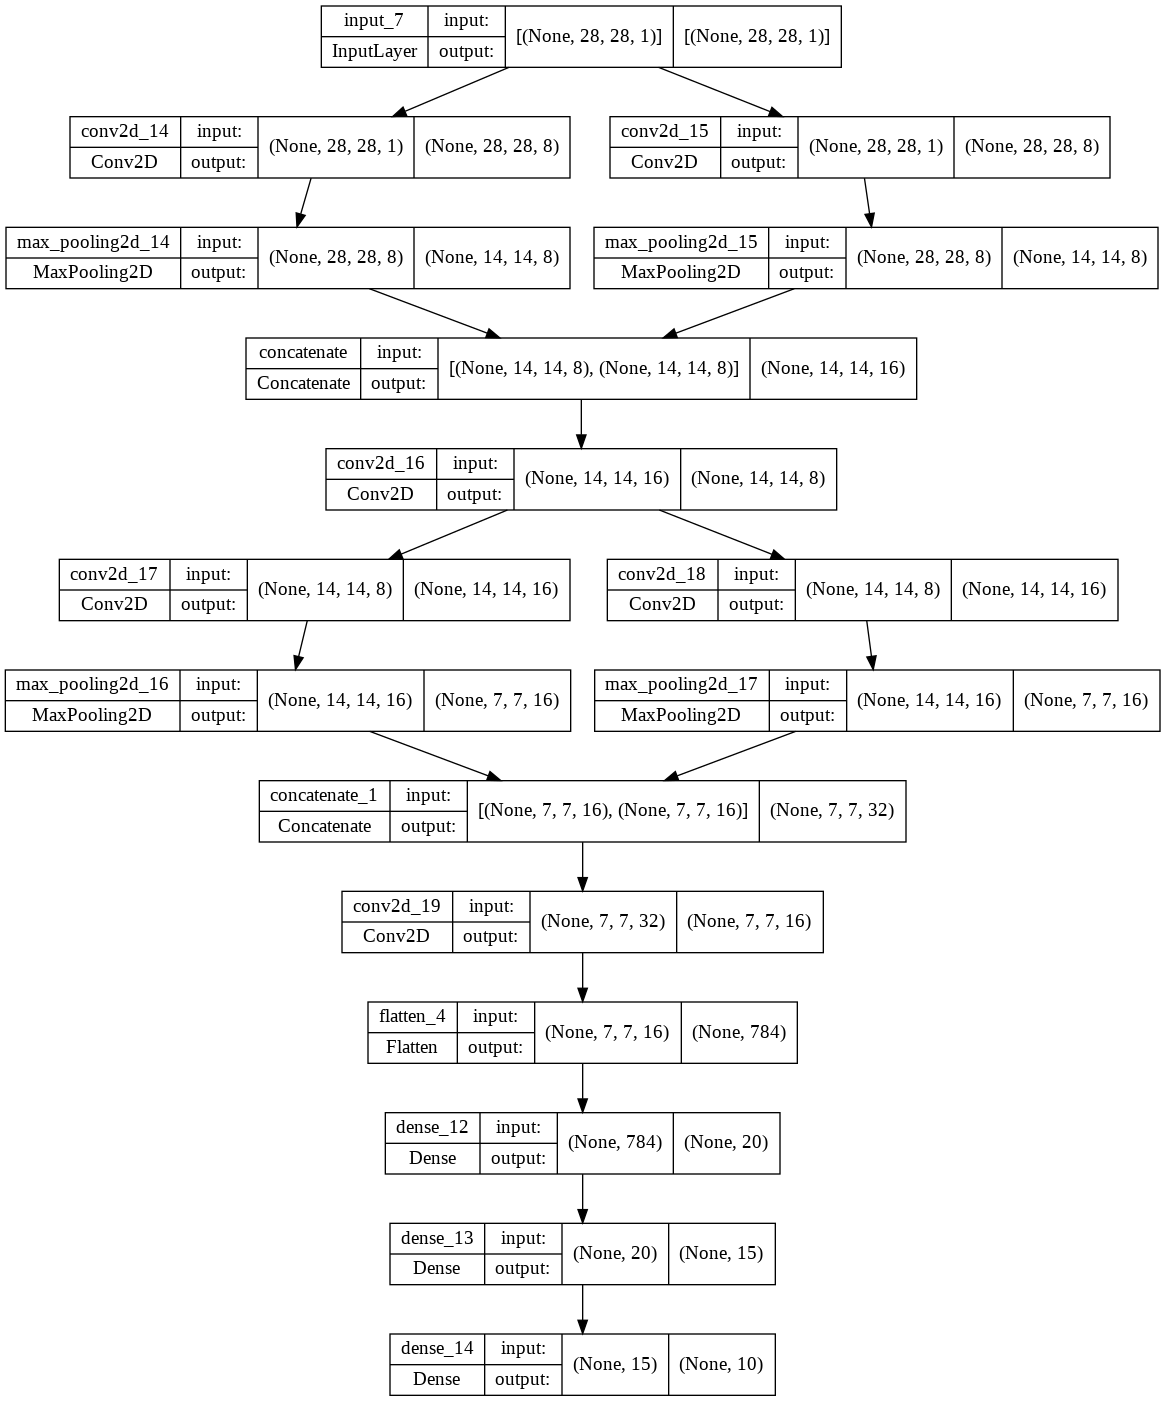

In [37]:
par_model = build_parallel_functional_model(**model_arguments)
# generate a graphical representation of the neural network
plot_model(par_model, show_shapes=True, show_layer_names=True, to_file='par_model.png')
# display the graphical representation
Image('par_model.png')